# Retrieval Evaluation

In [1]:
# %pip install "haystack-ai>=2.15.0rc1"
# %pip install ragas-haystack
# %pip install nltk
# %pip install openai
# %pip install pandas
# %pip install ragas-haystack
# %pip install "sentence-transformers>=3.0.0"
# %pip install hf_xet
# %pip install "ollama-haystack==2.4.2"
# %pip install tqdm # For Progress Bar
# %pip install einops

In [1]:
import os
from haystack.document_stores.in_memory import InMemoryDocumentStore
import importlib
from datetime import datetime
from tqdm import tqdm
import pandas as pd
tqdm.pandas()
import logging
from utils.pickle_utils import for_each_pickle_file
from pipelines.evaluation.base_retrieval_eval_pipeline import get_base_retrieval_eval_pipeline
from models import EmbeddingModelConfig, EmbeddingModelProvider, RerankingModelConfig, RerankingModelProvider, LLMConfig, LLMProvider
logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logging.getLogger("haystack").setLevel(logging.WARNING)

os.environ["SENTENCE_TRANSFORMERS_HOME"] = "./model-assets/sentence-transformers"
os.environ["HF_HUB_CACHE"] = "./model-assets/hugging-face"


In [2]:
FINAL_TOP_K = 10 # Number of documents returned at the end of pipeline
NUMBER_OF_QUESTIONS_IN_EVAL = 1


In [3]:
test_configs = [
    {
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-4B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": LLMConfig(name="gemma3:12b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 10,
    },
    {
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-4B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-0.6B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:12b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 10,
    },
    {
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-4B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-0.6B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:12b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 20,
    },
    {
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-4B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-0.6B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:12b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 40,
    },
    {
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-4B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-0.6B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:12b", provider=LLMProvider.OLLAMA),
        "retrieval-top-k": 80,
    },
]

In [4]:
now = datetime.now()

def run_retrieval_eval(filename, df):
    import config.prompt
    importlib.reload(config.prompt)

    import re

    match = re.search(r"answers_(.*?)_dataset", filename)
    if match:
        splitting_strategy = match.group(1)
    else:
        splitting_strategy = None

    # 1) Filter out the null‐question rows
    df_nonnull = df[df["question"].notnull()]

    df_shuffled = df_nonnull.sample(n=NUMBER_OF_QUESTIONS_IN_EVAL, random_state=42).reset_index(drop=True)

    for index, row in tqdm(
        df_shuffled.iterrows(),
        total=len(df_shuffled),
        desc="Processing rows",
        unit="row"
    ):
        relevant_documents = row["documents"]
        question = row["question"]

        for test_config in test_configs:
            base_indexing_store = InMemoryDocumentStore.load_from_disk(f"data/document_stores/{test_config['embedding_model'].name}/context/{test_config['contextualizer_model'].name}/{splitting_strategy}_indexing_store.json")
            pipeline = get_base_retrieval_eval_pipeline(
                base_indexing_store=base_indexing_store,
                embedding_model_config=test_config["embedding_model"],
                reranking_model_config=test_config["reranking_model"],
            )
            request_payload = {
                "retriever": {
                    "top_k": test_config["retrieval-top-k"],
                },
                "map_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "mrr_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "recall_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                }
            }
            if "query_embedder" in pipeline.graph.nodes:
                request_payload["query_embedder"] = {
                    "text": question,
                }
            if "reranker" in pipeline.graph.nodes:
                request_payload["reranker"] = {
                    "query": question,
                    "top_k": FINAL_TOP_K,
                }
            result = pipeline.run(request_payload)

            map_score = result.get("map_evaluator", {}).get("score", {})
            mrr_score = result.get("mrr_evaluator", {}).get("score", {})
            recall_score = result.get("recall_evaluator", {}).get("score", {})

            df.at[index, f"{test_config['reranking_model']}_{test_config['retrieval-top-k']}_map"] = map_score
            df.at[index, f"{test_config['reranking_model']}_{test_config['retrieval-top-k']}_mrr"] = mrr_score
            df.at[index, f"{test_config['reranking_model']}_{test_config['retrieval-top-k']}_recall"] = recall_score

    save_path = f"results/retrieval/reranker/{now.strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_pickle(save_path)

df = pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_word_50_10_dataset_flat.pkl")
run_retrieval_eval("question_answers_docs_word_50_10_dataset_flat.pkl", df)

Processing rows:   0%|          | 0/1 [00:00<?, ?row/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

left
['yes', 'no']
left
['yes', 'no']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

left
['yes', 'no']
left
['yes', 'no']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

left
['yes', 'no']
left
['yes', 'no']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

left
['yes', 'no']


Processing rows:   0%|          | 0/1 [00:20<?, ?row/s]


ImportError: 
 requires the protobuf library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/protocolbuffers/protobuf/tree/master/python#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


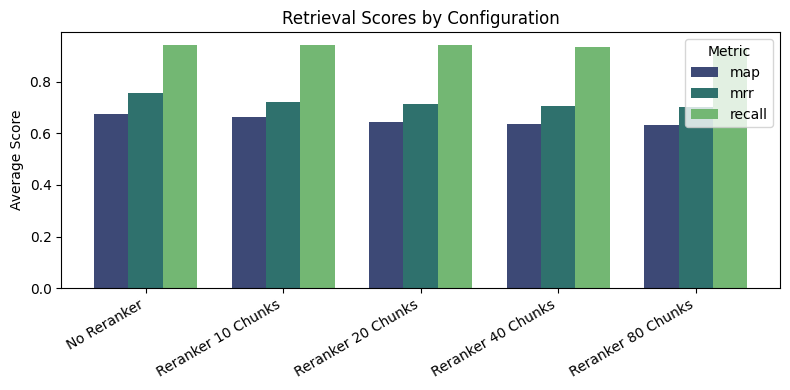

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# 1) Load your DF
df = pd.read_pickle("results/retrieval/reranker/2025-07-10_15-35-11.pkl")

# 2) Find all the *_map, *_mrr, *_recall columns
score_cols = [c for c in df.columns if re.search(r"_(map|mrr|recall)$", c)]

# 3) Compute the mean score for each
mean_scores = df[score_cols].mean()

# 4) Build a clean label for each column
records = []
for col in score_cols:
    m = re.match(r"(?P<model>.+?)_(?P<k>\d+)_(?P<metric>map|mrr|recall)$", col)
    if not m:
        continue
    model, k_str, metric = m.group("model"), m.group("k"), m.group("metric")
    label = "No Reranker" if model == "None" else f"Reranker {k_str} Chunks"
    records.append({
        "label":  label,
        "metric": metric,
        "score":  mean_scores[col]
    })

plot_df = pd.DataFrame(records)

# 5) Collapse duplicates just in case
agg = plot_df.groupby(["label","metric"], as_index=False)["score"].mean()

# 6) Pivot to wide form
pivot = agg.pivot(index="label", columns="metric", values="score")

# 7) Only keep & order the labels you care about
desired = [
    "No Reranker",
    "Reranker 10 Chunks",
    "Reranker 20 Chunks",
    "Reranker 40 Chunks",
    "Reranker 80 Chunks",
]
present = [lbl for lbl in desired if lbl in pivot.index]
pivot = pivot.loc[present]

# 8) Define your custom colors (from your screenshot)
colors = {
    "map":    "#3D4976",   # navy
    "mrr":    "#2F716D",   # teal
    "recall": "#73B773",   # green
}

# 9) Plot
x     = np.arange(len(pivot))
width = 0.25

fig, ax = plt.subplots(figsize=(8,4))
for i, metric in enumerate(pivot.columns):
    ax.bar(
        x + width*i,
        pivot[metric],
        width=width,
        label=metric,
        color=colors[metric]
    )

ax.set_xticks(x + width*(len(pivot.columns)-1)/2)
ax.set_xticklabels(pivot.index, rotation=30, ha="right")
ax.set_ylabel("Average Score")
ax.set_title("Retrieval Scores by Configuration")
ax.legend(title="Metric")
plt.tight_layout()
plt.show()

In [2]:
df

,question,references,groundTruth,source_file,variations_pretty,documents,variant,prev_messages,None_10_map,None_10_mrr,...,<models.reranking_model_config.RerankingModelConfig object at 0x7fee9a60fbd0>_10_recall,<models.reranking_model_config.RerankingModelConfig object at 0x7fee9a60fc50>_20_map,<models.reranking_model_config.RerankingModelConfig object at 0x7fee9a60fc50>_20_mrr,<models.reranking_model_config.RerankingModelConfig object at 0x7fee9a60fc50>_20_recall,<models.reranking_model_config.RerankingModelConfig object at 0x7fed690d8c90>_40_map,<models.reranking_model_config.RerankingModelConfig object at 0x7fed690d8c90>_40_mrr,<models.reranking_model_config.RerankingModelConfig object at 0x7fed690d8c90>_40_recall,<models.reranking_model_config.RerankingModelConfig object at 0x7fed690d8a50>_80_map,<models.reranking_model_config.RerankingModelConfig object at 0x7fed690d8a50>_80_mrr,<models.reranking_model_config.RerankingModelConfig object at 0x7fed690d8a50>_80_recall
0,Wie läuft eine äußere Wendung genau ab und was...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,default,[],1.00000,1.000000,...,1.0,0.500000,0.500000,1.0,0.500000,0.500000,1.0,0.500000,0.500000,1.0
1,Und was passiert dann genau davor?,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,contextual,"[Ich habe von der äußeren Wendung gehört, könn...",0.18254,0.142857,...,1.0,0.555556,0.500000,1.0,0.555556,0.500000,1.0,0.531746,0.500000,1.0
2,Wie genau läuft so ne äußere Wendung ab und wa...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,slang,[],1.00000,1.000000,...,1.0,0.416667,0.333333,1.0,0.416667,0.333333,1.0,0.416667,0.333333,1.0
3,How is an external version performed exactly a...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,english,[],0.50000,0.500000,...,1.0,0.750000,1.000000,1.0,0.750000,1.000000,1.0,0.750000,1.000000,1.0
4,äußere Wendung Ablauf Vorbereitung,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,keyword,[],0.12500,0.125000,...,1.0,0.100000,0.100000,1.0,0.100000,0.100000,1.0,0.100000,0.100000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,Risiken Ballonkatheter?,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=b92aa18d221df9e8cbef44cd1db9e8a52...,short,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,"Ich möchte wissen, welche möglichen Komplikati...",[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=b92aa18d221df9e8cbef44cd1db9e8a52...,long,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,Welche potenziellen Komplikationen und Risiken...,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=b92aa18d221df9e8cbef44cd1db9e8a52...,technical,[],NaN,NaN,...,NaN